In [1]:
import warnings
warnings.filterwarnings('ignore')
import importlib

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

from scipy.interpolate import interp1d
from scipy import optimize
from scipy.optimize import basinhopping

from gaus_vertex import *
import time

In [2]:
def calc_monomer_matrix_4_lengthpoly(poly_mat, dens):
    # calculates the AAAA monomer identity cross correlation matrix
    # assumes all polymers same length/ # of monomers, equal volume fraction of each
    
    # polymat - each row is a polymer
    # dens is an array where each entry is rel vol frac of correponding polymer
    poly_mat = np.array(poly_mat)
    
    if len(np.shape(poly_mat)) == 1: # single poly
        n_p = 1
        M = len(poly_mat)
        alph1 =np.zeros(M)
        alph2 =np.zeros(M)
        alph3 =np.zeros(M)
        alph4 =np.zeros(M)

        sig1 = 1*(poly_mat == alph1)
        sig2 = 1*(poly_mat == alph2)
        sig3 = 1*(poly_mat == alph3)
        sig4 = 1*(poly_mat == alph3)

        M4_AAAA = np.einsum('i,j,k,l',sig1,sig2,sig3,sig4)
        return M4_AAAA
    
    # find poly with largest M
    # pad all other polys with monomer type 2
    # then repackage as polymat, go thorugh same anlaysis
    M_max = max(M_arr)
    new_poly_mat = []
    for i, poly in enumerate(poly_mat):
        M_p = M_arr[i]
        if M_p < M_max:
            new_poly = poly + [2]*(M_max - M_p)
            new_poly_mat.append(new_poly)
        else:
            new_poly_mat.append(poly)
        
    poly_mat = new_poly_mat
    n_p = len(M_arr)#poly_mat.shape[0]
    alph1 =np.zeros((n_p, M_max))
    alph2 =np.zeros((n_p, M_max))
    alph3 =np.zeros((n_p, M_max))
    alph4 =np.zeros((n_p, M_max))
    
    #extend dens into n_pxM matrix
    poly_weights = (np.ones((n_p, M_max)).T * dens).T
    
    #multiply sigams by density of each polymer
    sigma1 = 1*((poly_mat == alph1))#.sum(axis = 0) #sigma. could multiply each
    sigma2 = 1*((poly_mat == alph2))#.sum(axis = 0)
    sigma3 = 1*((poly_mat == alph3))
    sigma4 = 1*((poly_mat == alph4))
    
    #need to do each row outer product with corresponding row, get n_p MxMxM matrices, then sum the results
    prods = np.einsum('bi,bo,bn,bm->bionm', sigma1*poly_weights, sigma2, sigma3, sigma4) # performing row wise cross product (each poly contribution)
    M4_AAAA = np.sum(prods, axis = 0)#           ^^^^ averaging each contribution
    return M4_AAAA

def calc_sf4_lengthpoly(poly_mat, dens, N_m, b, k_vec, k_vec_2, k_vec_3, plotting = False):
    M4_AAAA = calc_monomer_matrix_4(poly_mat, dens)
    M = np.shape(M4_AAAA)[0]
    nk = len(k_vec)
#     N = M*N_m
    if len(dens) == 1:
        N = M*N_m
    else:
        N = 0
        for i in range(len(M_arr)):
            m = M_arr[i]
            phi = dens[i]
            N += (m * N_m * phi)

    grid = np.indices((M,M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    j4 = grid[3]
    
    S4_AAAA_arr = np.zeros(nk)
    
    S4_BAAA_arr = np.zeros(nk)
    S4_ABAA_arr = np.zeros(nk)
    S4_AABA_arr = np.zeros(nk)
    S4_AAAB_arr = np.zeros(nk)
    
    S4_AABB_arr = np.zeros(nk)
    S4_BBAA_arr = np.zeros(nk)
    S4_ABBA_arr = np.zeros(nk)
    S4_BAAB_arr = np.zeros(nk)
    S4_ABAB_arr = np.zeros(nk)
    S4_BABA_arr = np.zeros(nk)

    S4_ABBB_arr = np.zeros(nk)
    S4_BABB_arr = np.zeros(nk)
    S4_BBAB_arr = np.zeros(nk)
    S4_BBBA_arr = np.zeros(nk)
    
    S4_BBBB_arr = np.zeros(nk)
    
    
    M4_BAAA = M4_AAAA[j2, j2, j3, j4] - M4_AAAA
    M4_BBAA = M4_BAAA[j1, j3, j3, j4] - M4_BAAA
    M4_BBBA = M4_BBAA[j1, j2, j4, j4] - M4_BBAA
    M4_BBBB = 1 - M4_AAAA[j1, j1, j1, j1] - M4_AAAA[j2, j2, j2, j2] - M4_AAAA[j3, j3, j3, j3]  + M4_AAAA[j1, j1, j3, j3]\
    + M4_AAAA[j2, j2, j3, j3] + M4_AAAA[j1, j1, j2, j2] - M4_AAAA[j1, j2, j3, j3] - M4_BBBA

    M4_ABAB = M4_AAAA[j1, j1, j3, j3] - M4_AAAA[j1, j1, j3, j4] - M4_AAAA[j1, j1, j2, j3] + M4_AAAA
    M4_ABBA = M4_AAAA[j1,j1,j4,j4] - M4_AAAA[j1, j1, j4, j3] - M4_AAAA[j1, j1, j2, j4] + M4_AAAA[j1, j2, j4, j3]
    M4_BBAB = M4_ABBA[j3, j2, j4, j3] - M4_ABBA[j1, j2, j4, j3]
    M4_BABB = M4_ABBA[j2, j4, j3, j2] - M4_ABBA[j1, j4, j3, j2]
    M4_ABBB = M4_ABBA[j1, j2, j3, j1] - M4_ABBA[j4, j2, j3, j1]
    
    M4_AAAB = M4_AAAA[j1, j2, j3, j3] - M4_AAAA
    M4_AABA = M4_AAAA[j1, j2, j2, j4] - M4_AAAA
    M4_ABAA = M4_AAAA[j1, j1, j3, j4] - M4_AAAA
    M4_AABB = M4_AABA[j1, j2, j3, j1] - M4_AABA
    M4_BAAB = M4_BAAA[j1, j2, j3, j3] - M4_BAAA
    M4_BABA = M4_BAAA[j1, j2, j2 ,j4] - M4_BAAA
    
    for i, k1 in enumerate(k_vec):
        k2 = k_vec_2[i]
        k3 = k_vec_3[i]
        k12 = k1 + k2
        k13 = k1 + k3
        k23 = k2 + k3
        k123 = k1 + k2 + k3
        
        # CASE 1; kA = k1 + k2 + k3; kB = k_1 + k_2; kC = k_1  S4 > S3 > S2 > S1 (and reverse). All cases on wlcstat
        case1 = [[k123, k12, k1], [j4, j3, j2, j1]]
        case2 = [[k123, k12, k2], [j4, j3, j1, j2]]
        case3 = [[k123, k13, k1], [j4, j2, j3, j1]]
        case4 = [[k123, k23, k2], [j4, j1, j3, j2]]
        case5 = [[k123, k13, k3], [j4, j2, j1, j3]]
        case6 = [[k123, k23, k3], [j4, j1, j2, j3]]
        case7 = [[-k3, k12, k1], [j3, j4, j2, j1]]
        case8 = [[-k3, k12, k2], [j3, j4, j1, j2]]
        case9 = [[-k2, k13, k1], [j2, j4, j3, j1]]
        case10 = [[-k1, k23, k2], [j1, j4, j3, j2]]
        case11 = [[-k2, k13, k3], [j2, j4, j1, j3]]
        case12 = [[-k1, k23, k3], [j1, j4, j2, j3]]
        
#         case1_deg = [[k1, k12, k123], [j1, j2, j3, j4]]
#         case2_deg = [[k2, k12, k123], [j2, j1, j3, j4]]
#         case3_deg = [[k1, k13, k123], [j1, j3, j2, j4]]
#         case4_deg = [[k2, k23, k123], [j2, j3, j1, j4]]
#         case5_deg = [[k3, k13, k123], [j3, j1, j2, j4]]
#         case6_deg = [[k3, k23, k123], [j3, j2, j1, j4]]
#         case7_deg = [[k1, k12, -k3], [j1, j2, j4, j3]]
#         case8_deg = [[k2, k12, -k3], [j2, j1, j4, j3]]
#         case9_deg = [[k1, k13, -k2], [j1, j3, j4, j2]]
#         case10_deg = [[k2, k23, -k1], [j2, j3, j4, j1]]
#         case11_deg = [[k3, k13, -k2], [j3, j1, j4, j2]]
#         case12_deg = [[k3, k23, -k1], [j3, j2, j4, j1]]



        case_arr = [case1, case2, case3, case4, case5, case6, \
                   case7, case8, case9, case10, case11, case12, ]#\
#                     case1_deg, case2_deg, case3_deg, case4_deg, case5_deg, case6_deg, \
#                    case7_deg, case8_deg, case9_deg, case10_deg, case11_deg, case12_deg]
#         print("FASTER??") nope
        # need to consider degenerate cases. flipping each element in array, then appending to original case array
        case_arr = np.vstack((case_arr, [[np.flipud(el) for el in cse] for cse in case_arr]))
        
#        for each case and sub case, add to a matrix C(j1, j2, j3, j4) which contains the contribution to the overall S4
#        then sum over all indices. Need to keep track of js so that aproiate multiplications with cross corr matrix M4 
        C = np.zeros((M,M,M,M))
        for cse in case_arr:
            kA, kB, kC = cse[0]
            ordered_js = cse[1]
            
            xm_A = (1/6) * N_m * b**2 * np.linalg.norm(kA)**2
            xm_B = (1/6) * N_m * b**2 * np.linalg.norm(kB)**2
            xm_C = (1/6) * N_m * b**2 * np.linalg.norm(kC)**2
            
            C = calc_case_s4(C, xm_A, xm_B, xm_C, ordered_js)
            
        S4_AAAA_arr[i] += np.sum((1/M**4) * M4_AAAA * C)*(N**4)
        
        S4_BAAA_arr[i] += np.sum((1/M**4) * M4_BAAA * C)*(N**4)
        S4_ABAA_arr[i] += np.sum((1/M**4) * M4_ABAA * C)*(N**4)
        S4_AABA_arr[i] += np.sum((1/M**4) * M4_AABA * C)*(N**4)
        S4_AAAB_arr[i] += np.sum((1/M**4) * M4_AAAB * C)*(N**4)

        S4_AABB_arr[i] += np.sum((1/M**4) * M4_AABB * C)*(N**4)        
        S4_BBAA_arr[i] += np.sum((1/M**4) * M4_BBAA * C)*(N**4)
        S4_ABBA_arr[i] += np.sum((1/M**4) * M4_ABBA * C)*(N**4)
        S4_BAAB_arr[i] += np.sum((1/M**4) * M4_BAAB * C)*(N**4)
        S4_ABAB_arr[i] += np.sum((1/M**4) * M4_ABAB * C)*(N**4)
        S4_BABA_arr[i] += np.sum((1/M**4) * M4_BABA * C)*(N**4)

        S4_ABBB_arr[i] += np.sum((1/M**4) * M4_ABBB * C)*(N**4)
        S4_BABB_arr[i] += np.sum((1/M**4) * M4_BABB * C)*(N**4)
        S4_BBAB_arr[i] += np.sum((1/M**4) * M4_BBAB * C)*(N**4)
        S4_BBBA_arr[i] += np.sum((1/M**4) * M4_BBBA * C)*(N**4)

        S4_BBBB_arr[i] += np.sum((1/M**4) * M4_BBBB * C)*(N**4)
        
        
    s4 = np.zeros((2, 2, 2, 2))
    
    s4[0][0][0][0] = S4_AAAA_arr[0]
    s4[0][0][0][1] = S4_AAAB_arr[0]
    s4[0][0][1][0] = S4_AABA_arr[0]
    s4[0][1][0][0] = S4_ABAA_arr[0]
    s4[1][0][0][0] = S4_BAAA_arr[0]
    s4[0][0][1][1] = S4_AABB_arr[0]
    s4[1][1][0][0] = S4_BBAA_arr[0]
    s4[1][0][0][1] = S4_BAAB_arr[0]
    s4[0][1][1][0] = S4_ABBA_arr[0]
    s4[1][0][1][0] = S4_BABA_arr[0]
    s4[0][1][0][1] = S4_ABAB_arr[0]
    s4[1][1][1][0] = S4_BBBA_arr[0]
    s4[1][1][0][1] = S4_BBAB_arr[0]
    s4[1][0][1][1] = S4_BABB_arr[0]
    s4[0][1][1][1] = S4_ABBB_arr[0]
    s4[1][1][1][1] = S4_BBBB_arr[0]
    
    if plotting: # matrix only contains single value, for calculating gamma functions
#         raise Exception("need to fix return value")
        return S4_AAAA_arr, S4_AAAB_arr, S4_AABA_arr, S4_ABAA_arr, S4_BAAA_arr, S4_AABB_arr, S4_BBAA_arr, S4_BAAB_arr, S4_ABBA_arr, S4_BABA_arr, S4_ABAB_arr, S4_BBBA_arr, S4_BBAB_arr, S4_BABB_arr, S4_ABBB_arr, S4_BBBB_arr 
    
    return s4 


In [21]:
FA = 0.5
N = 10000

# poly_mat = [0,1,1,1,0,1,0,0]
# M = 8
# dens = [1.]

# poly_mat = [[1,1,1,0], [0,1,0,1]]
# M = 4
# M_arr = [4,4]
# dens = [0.34, 0.66]

poly_mat = [[1,1,1,1], [1,1,1]]
M = 4
M_arr = [4,3]
dens = [0.34, 0.66]

N_m = N / M
b=1
k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)#*rg2**0.5

k1_vec = np.zeros((nk, 3))
k2_vec = np.zeros((nk, 3))
k3_vec = np.zeros((nk, 3))

k1_vec[:, 0] += np.logspace(np.log10(k0), np.log10(kf), nk)#*rg2**0.5

theta_1 = 0#np.pi#np.pi/3 #2* np.pi * 1 / 3
theta_2 = 2*np.pi/3

frac = 1
frac_2 = 2
k2_vec[:, 0] += frac * np.cos(theta_1) * np.logspace(np.log10(k0), np.log10(kf), nk)
k2_vec[:, 1] += frac * np.sin(theta_1) * np.logspace(np.log10(k0), np.log10(kf), nk)

k3_vec[:, 0] += frac_2 * np.cos(theta_2) * np.logspace(np.log10(k0), np.log10(kf), nk)
k3_vec[:, 1] += frac_2 * np.sin(theta_2) * np.logspace(np.log10(k0), np.log10(kf), nk)


k4_vec = - (k1_vec + k2_vec + k3_vec)

k1_val = np.sqrt(np.sum(k1_vec ** 2,axis = 1))
k2_val = np.sqrt(np.sum(k2_vec ** 2,axis = 1))
k3_val = np.sqrt(np.sum(k3_vec ** 2,axis = 1))

In [22]:
%%time
s4_gaus_AAAA, s4_gaus_AAAB, s4_gaus_AABA, s4_gaus_ABAA,\
s4_gaus_BAAA, s4_gaus_AABB, s4_gaus_BBAA, s4_gaus_BAAB,\
s4_gaus_ABBA, s4_gaus_BABA, s4_gaus_ABAB, s4_gaus_BBBA,\
s4_gaus_BBAB, s4_gaus_BABB, s4_gaus_ABBB, s4_gaus_BBBB  = calc_sf4(poly_mat, dens, N_m, b, k1_vec, k2_vec, k3_vec, plotting = True)

Wall time: 587 ms


In [23]:
%%time
s4_lengthpoly_AAAA, s4_lengthpoly_AAAB, s4_lengthpoly_AABA, s4_lengthpoly_ABAA,\
s4_lengthpoly_BAAA, s4_lengthpoly_AABB, s4_lengthpoly_BBAA, s4_lengthpoly_BAAB,\
s4_lengthpoly_ABBA, s4_lengthpoly_BABA, s4_lengthpoly_ABAB, s4_lengthpoly_BBBA,\
s4_lengthpoly_BBAB, s4_lengthpoly_BABB, s4_lengthpoly_ABBB, s4_lengthpoly_BBBB  = calc_sf4_lengthpoly(poly_mat, dens, N_m, b, k1_vec, k2_vec, k3_vec, plotting = True)

Wall time: 593 ms


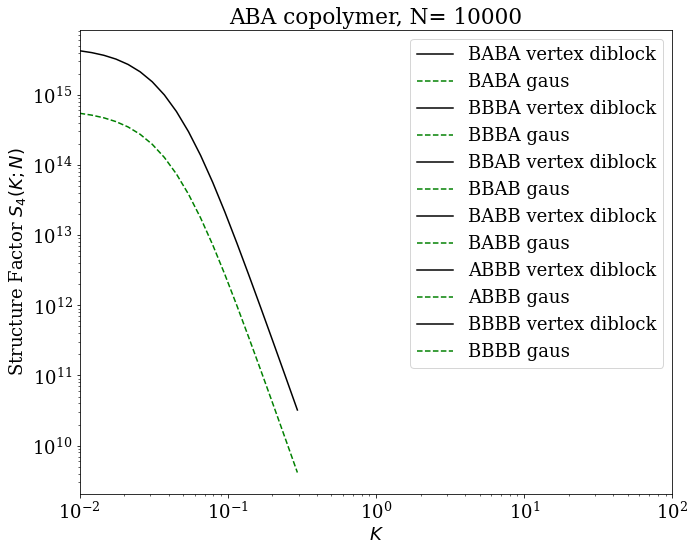

In [24]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.plot(k_vec[:], s4_lengthpoly_AAAA[:], label = "AAAA vertex diblock", linestyle = "-", color = "blue")
# plt.plot(k_vec[:], s4_gaus_AAAA[:], label = "AAAA gaus", linestyle = "--", color = "green", alpha = 1)
# # plt.plot(k_vec[:], s4_gaus_cga_AAAA[:], label = "AAAA gaus_cga", linestyle = "--", color = "pink")

# plt.plot(k_vec[:], s4_lengthpoly_AAAB[:], label = "AAAB vertex diblock", linestyle = "-", color = "blue")
# plt.plot(k_vec[:], s4_gaus_AAAB[:], label = "AAAB gaus", linestyle = "--", color = "green", alpha = 1)
# # plt.plot(k_vec[:], s4_gaus_cga_AAAB[:], label = "AAAB gaus_cga", linestyle = "--", color = "pink")

# plt.plot(k_vec[:], s4_lengthpoly_AABA[:], label = "AABA vertex diblock", linestyle = "-", color = "blue")
# plt.plot(k_vec[:], s4_gaus_AABA[:], label = "AABA gaus", linestyle = "--", color = "green", alpha = 1)
# # plt.plot(k_vec[:], s4_gaus_cga_AABA[:], label = "AABA gaus_cga", linestyle = "--", color = "pink", alpha = 1)

# plt.plot(k_vec[:], s4_lengthpoly_ABAA[:], label = "ABAA vertex diblock", linestyle = "-", color = "blue")
# plt.plot(k_vec[:], s4_gaus_ABAA[:], label = "ABAA gaus", linestyle = "--", color = "green", alpha = 1)
# # plt.plot(k_vec[:], s4_gaus_cga_ABAA[:], label = "ABAA gaus_cga", linestyle = "--", color = "pink", alpha = 1)

# plt.plot(k_vec[:], s4_lengthpoly_BAAA[:], label = "BAAA vertex diblock", linestyle = "-", color = "blue")
# plt.plot(k_vec[:], s4_gaus_BAAA[:], label = "BAAA gaus", linestyle = "--", color = "green", alpha = 1)
# # plt.plot(k_vec[:], s4_gaus_cga_BAAA[:], label = "BAAA gaus_cga", linestyle = "--", color = "pink", alpha = 1)

# plt.plot(k_vec[:], s4_lengthpoly_AABB[:], label = "AABB vertex diblock", linestyle = "-", color = "blue")
# plt.plot(k_vec[:], s4_gaus_AABB[:], label = "AABB gaus", linestyle = "--", color = "green", alpha = 1)
# plt.plot(k_vec[:], s4_gaus_cga_AABB[:], label = "AABB gaus_cga", linestyle = "--", color = "pink", alpha = 1)

# plt.plot(k_vec[:], s4_lengthpoly_BBAA[:], label = "BBAA vertex diblock", linestyle = "-", color = "blue")
# plt.plot(k_vec[:], s4_gaus_BBAA[:], label = "BBAA gaus", linestyle = "--", color = "green", alpha = 1)
# plt.plot(k_vec[:], s4_gaus_cga_BBAA[:], label = "BBAA gaus_cga", linestyle = "--", color = "pink", alpha = 1)

# plt.plot(k_vec[:], s4_lengthpoly_BAAB[:], label = "BAAB vertex diblock", linestyle = "-", color = "black")
# plt.plot(k_vec[:], s4_gaus_BAAB[:], label = "BAAB gaus", linestyle = "--", color = "green", alpha = 1)
# plt.plot(k_vec[:], s4_gaus_cga_BAAB[:], label = "BAAB gaus_cga", linestyle = "--", color = "pink", alpha = 1)

# plt.plot(k_vec[:], s4_lengthpoly_ABBA[:], label = "ABBA vertex diblock", linestyle = "-", color = "black")
# plt.plot(k_vec[:], s4_gaus_ABBA[:], label = "ABBA gaus", linestyle = "--", color = "green", alpha = 1)
# plt.plot(k_vec[:], s4_gaus_cga_ABBA[:], label = "ABBA gaus_cga", linestyle = "--", color = "pink", alpha = 1)

# plt.plot(k_vec[:], s4_lengthpoly_ABAB[:], label = "ABAB vertex diblock", linestyle = "-", color = "black")
# plt.plot(k_vec[:], s4_gaus_ABAB[:], label = "ABAB gaus", linestyle = "--", color = "green", alpha = 1)
# plt.plot(k_vec[:], s4_gaus_cga_ABAB[:], label = "ABAB gaus_cga", linestyle = "--", color = "pink", alpha = 1)

plt.plot(k_vec[:], s4_lengthpoly_BABA[:], label = "BABA vertex diblock", linestyle = "-", color = "black")
plt.plot(k_vec[:], s4_gaus_BABA[:], label = "BABA gaus", linestyle = "--", color = "green", alpha = 1)
# plt.plot(k_vec[:], s4_gaus_cga_BABA[:], label = "BABA gaus_cga", linestyle = "--", color = "pink", alpha = 1)

plt.plot(k_vec[:], s4_lengthpoly_BBBA[:], label = "BBBA vertex diblock", linestyle = "-", color = "black")
plt.plot(k_vec[:], s4_gaus_BBBA[:], label = "BBBA gaus", linestyle = "--", color = "green", alpha = 1)
# plt.plot(k_vec[:], s4_gaus_cga_BBBA[:], label = "BBBA gaus_cga", linestyle = "--", color = "pink", alpha = 1)

plt.plot(k_vec[:], s4_lengthpoly_BBAB[:], label = "BBAB vertex diblock", linestyle = "-", color = "black")
plt.plot(k_vec[:], s4_gaus_BBAB[:], label = "BBAB gaus", linestyle = "--", color = "green", alpha = 1)
# plt.plot(k_vec[:], s4_gaus_cga_BBAB[:], label = "BBAB gaus_cga", linestyle = "--", color = "pink", alpha = 1)

plt.plot(k_vec[:], s4_lengthpoly_BABB[:], label = "BABB vertex diblock", linestyle = "-", color = "black")
plt.plot(k_vec[:], s4_gaus_BABB[:], label = "BABB gaus", linestyle = "--", color = "green", alpha = 1)
# plt.plot(k_vec[:], s4_gaus_cga_BABB[:], label = "BABB gaus_cga", linestyle = "--", color = "pink", alpha = 1)

plt.plot(k_vec[:], s4_lengthpoly_ABBB[:], label = "ABBB vertex diblock", linestyle = "-", color = "black")
plt.plot(k_vec[:], s4_gaus_ABBB[:], label = "ABBB gaus", linestyle = "--", color = "green", alpha = 1)
# plt.plot(k_vec[:], s4_gaus_cga_ABBB[:], label = "ABBB gaus_cga", linestyle = "--", color = "pink", alpha = 1)

plt.plot(k_vec[:], s4_lengthpoly_BBBB[:], label = "BBBB vertex diblock", linestyle = "-", color = "black")
plt.plot(k_vec[:], s4_gaus_BBBB[:], label = "BBBB gaus", linestyle = "--", color = "green", alpha = 1)
# plt.plot(k_vec[:], s4_gaus_cga_BBBB[:], label = "BBBB gaus_cga", linestyle = "--", color = "pink", alpha = 1)

plt.xscale('log')
plt.yscale('log')

plt.title("ABA copolymer, N= " + str(N))# + ", $f_A$ = " + str(FA))
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{4}(K;N)$')
plt.xlim((1e-2, 1e2))
# plt.ylim((1e-5, 1e10))
plt.tight_layout()
plt.legend()
plt.show()

In [14]:
def calc_monomer_matrix_3_lengthpoly(poly_mat, dens, M_arr = []):
    # calculates the AAA monomer identity cross correlation matrix
    # assumes all polymers same length/ # of monomers, equal volume fraction of each
    
    # polymat - each row is a polymer
    # dens is an array where each entry is rel vol frac of correponding polymer
    
    poly_mat = np.array(poly_mat)

    if len(np.shape(poly_mat)) == 1: # single poly
        n_p = 1
        M = len(poly_mat)
        alph1 =np.zeros(M)
        alph2 =np.zeros(M)
        alph3 =np.zeros(M)
        sig1 = 1*(poly_mat == alph1)
        sig2 = 1*(poly_mat == alph2)
        sig3 = 1*(poly_mat == alph3)
#         M2_AA = np.outer(sig1, sig2)
        M3_AAA = np.einsum('i,j,k',sig1,sig2,sig3)
        return M3_AAA
    
    # find poly with largest M
    # pad all other polys with monomer type 2
    # then repackage as polymat, go thorugh same anlaysis
    M_max = max(M_arr)
    new_poly_mat = []
    for i, poly in enumerate(poly_mat):
        M_p = M_arr[i]
        if M_p < M_max:
            new_poly = poly + [2]*(M_max - M_p)
            new_poly_mat.append(new_poly)
        else:
            new_poly_mat.append(poly)
        
    poly_mat = new_poly_mat
    
    n_p = len(M_arr)
    alph1 =np.zeros((n_p, M_max))
    alph2 =np.zeros((n_p, M_max))
    alph3 =np.zeros((n_p, M_max))

    
    #extend dens into n_pxM matrix
    poly_weights = (np.ones((n_p, M_max)).T * dens).T
    
    #multiply sigams by density of each polymer
    sigma1 = 1*((poly_mat == alph1))#.sum(axis = 0) #sigma. could multiply each
    sigma2 = 1*((poly_mat == alph2))#.sum(axis = 0)
    sigma3 = 1*((poly_mat == alph3))
    
    #need to do each row outer product with corresponding row, get n_p MxMxM matrices, then sum the results
    prods = np.einsum('bi,bo,bn->bion', sigma1*poly_weights, sigma2, sigma3) # performing row wise cross product (each poly contribution)
    M3_AAA = np.sum(prods, axis = 0)#           ^^^^ averaging each contribution
    return M3_AAA


def calc_sf3_lengthpoly(poly_mat, dens, N_m, b, k_vec, k_vec_2, M_arr=[], plotting = False):
    # for a gaussian chain of M monomers, each of length N_m
    
    M3_AAA = calc_monomer_matrix_3(poly_mat, dens)
    M = np.shape(M3_AAA)[0]
    nk = len(k_vec)
#     N = M*N_m
    if len(dens) == 1:
        N = M*N_m
    else:
        N = 0
        for i in range(len(M_arr)):
            m = M_arr[i]
            phi = dens[i]
            N += (m * N_m * phi)

    grid = np.indices((M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    
    S3_AAA_arr =  np.zeros(nk)
    S3_BAA_arr = np.zeros(nk)
    S3_BBA_arr = np.zeros(nk)
    S3_BBB_arr = np.zeros(nk)
    
    S3_ABA_arr = np.zeros(nk)
    S3_BAB_arr = np.zeros(nk)
    
    S3_AAB_arr = np.zeros(nk)
    S3_ABB_arr = np.zeros(nk)

    
    M3_BAA = M3_AAA[j2, j2, j3] - M3_AAA
    M3_BBA = M3_AAA + M3_BAA[j1, j3, j3] - M3_AAA[j2,j2,j3]
    M3_BBB = 1  - M3_AAA[j1, j1, j1] - M3_BAA[j1, j2, j2] - M3_BAA[j1, j3, j3] + M3_AAA[j2,j2,j3] - M3_AAA
    
    M3_ABA = M3_AAA[j1,j1,j3] - M3_AAA
    M3_BAB = M3_AAA[j2,j2,j2] - M3_AAA[j2,j2,j3] - M3_AAA[j1,j2,j2] + M3_AAA
    M3_AAB = M3_AAA[j1, j1, j2] - M3_AAA
    M3_ABB = M3_AAA[j1,j1,j1] - M3_AAA[j1,j1,j2] - M3_AAA[j1,j1,j3] + M3_AAA
    
    
    for i, k_1 in enumerate(k_vec):
        k_2 = k_vec_2[i]
        k_12 = k_1 + k_2

        # CASE 1; kA = k1 + k2, kB = k_1; S3 > S2 > S1 and S1 > S2 > S3
        case1 = [[k_12, k_1], [j3, j2, j1]]

        # CASE 2; kA = k2, kB = k1 + k2; S2 > S1 > S3 and S3 > S1 > S2
        case2 = [[k_2, k_12], [j2, j1, j3]]
        
        # CASE 3; kA = k2, kB = -k1; S2 > S3 > S1 and S1 > S3 > S2
        case3 = [[-k_2, k_1], [j2, j3, j1]] # SWITCHED negatives from -k_1
        
        case_arr = [case1, case2, case3]#, case1deg, case2deg, case3deg]
        # need to consider degenerate cases. flipping each element in array, then appending to original case array
        case_arr = np.vstack((case_arr, [[np.flipud(el) for el in cse] for cse in case_arr]))
        
#        for each case and sub case, add to a matrix C(j1, j2, j3) which contains the contribution to the overall S3
#        then sum over all indices. Need to keep track of js so that aproiate multiplications with cross corr matrix M3        
        C = np.zeros((M,M,M))

        for cse in case_arr:
            kA, kB = cse[0]
            ordered_js = cse[1]
            
            xm_A = (1/6) * N_m * b**2 * np.linalg.norm(kA)**2
            xm_B = (1/6) * N_m * b**2 * np.linalg.norm(kB)**2
            
            C = calc_case_s3(C, xm_A, xm_B, ordered_js)
    
        S3_AAA_arr[i] += np.sum((1/M**3) * M3_AAA * C)*(N**3)
        S3_BAA_arr[i] += np.sum((1/M**3) * M3_BAA * C)*(N**3)
        S3_BBA_arr[i] += np.sum((1/M**3) * M3_BBA * C)*(N**3)
        S3_BBB_arr[i] += np.sum((1/M**3) * M3_BBB * C)*(N**3)
        
        S3_ABA_arr[i] += np.sum((1/M**3) * M3_ABA * C)*(N**3)
        S3_BAB_arr[i] += np.sum((1/M**3) * M3_BAB * C)*(N**3)
        
        S3_AAB_arr[i] += np.sum((1/M**3) * M3_AAB * C)*(N**3)
        S3_ABB_arr[i] += np.sum((1/M**3) * M3_ABB * C)*(N**3)
        
    s3 = np.zeros((2,2,2)) 
    s3[0][0][0] = S3_AAA_arr[0]
    s3[1][0][0] = S3_BAA_arr[0]
    s3[0][1][0] = S3_ABA_arr[0]
    s3[0][0][1] = S3_AAB_arr[0]
    s3[0][1][1] = S3_ABB_arr[0]
    s3[1][0][1] = S3_BAB_arr[0]
    s3[1][1][0] = S3_BBA_arr[0]
    s3[1][1][1] = S3_BBB_arr[0]
    
    if plotting: # matrix only contains single value, for calculating gamma functions
        return S3_AAA_arr, S3_AAB_arr, S3_ABA_arr, S3_BAA_arr, S3_ABB_arr, S3_BAB_arr,  S3_BBA_arr, S3_BBB_arr
    
    return s3


In [ ]:
# FA = 0.5
N = 1000

# poly_mat = [0,1,1,1,0,1,0,0]
# M = 8
# dens = [1.]

# poly_mat = [[1,1,1,0], [0,1,0,1]]
# M = 4
# M_arr = [4,4]
# dens = [0.34, 0.66]

poly_mat = [[1,1,1,1], [1,1,1]]
M = 4
M_arr = [4,3]
dens = [0.34, 0.66]

b = 1
N_m = N/M

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)#*rg2**0.5

k1_vec = np.zeros((nk, 3))
k2_vec = np.zeros((nk, 3))

k1_vec[:, 0] += np.logspace(np.log10(k0), np.log10(kf), nk)#*rg2**0.5
theta = 0#2*np.pi/3 #2* np.pi * 1 / 3

frac = 1
k2_vec[:, 0] += frac * np.cos(theta) * np.logspace(np.log10(k0), np.log10(kf), nk)
k2_vec[:, 1] += frac * np.sin(theta) * np.logspace(np.log10(k0), np.log10(kf), nk)
k3_vec = - k1_vec - k2_vec

k1_val = np.sqrt(np.sum(k1_vec ** 2,axis = 1))
k2_val = np.sqrt(np.sum(k2_vec ** 2,axis = 1))
k3_val = np.sqrt(np.sum(k3_vec ** 2,axis = 1))

# length_kuhn = 10.
# s3_th_theta0 = wlcstruc.s3_wlc(k1_vec, k2_vec, length_kuhn, dimensions = 3, alpha_max = 25)

In [ ]:
%%time
s3_lengthpoly_AAA , s3_lengthpoly_AAB, s3_lengthpoly_ABA,\
s3_lengthpoly_BAA, s3_lengthpoly_ABB, s3_lengthpoly_BAB,\
s3_lengthpoly_BBA, s3_lengthpoly_BBB = calc_sf3_lengthpoly(poly_mat, dens, N_m, b, k1_vec, k2_vec, M_arr, plotting = True)

In [ ]:
%%time
s3_gaus_AAA, s3_gaus_AAB, s3_gaus_ABA,\
s3_gaus_BAA, s3_gaus_ABB, s3_gaus_BAB,\
s3_gaus_BBA, s3_gaus_BBB = calc_sf3(poly_mat, dens, N_m, b, k1_vec, k2_vec, plotting = True)

In [ ]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)


plt.plot(k_vec[:], s3_lengthpoly_AAA[:], label = "AAA lengthpoly", linestyle = "-", color = "blue")
plt.plot(k_vec[:], s3_gaus_AAA[:], label = "AAA gaus", linestyle = "--", color = "red", alpha = 1)
# plt.plot(k_vec[:], s3_gaus_cga_AAA[:], label = "AAA gaus_cga", linestyle = "--", color = "pink")
# plt.plot(k_vec[:], s3_gaus_cga_AAA_dib[:], label = "AAA gaus_cga_dib", linestyle = "-", color = "black")

plt.plot(k_vec[:], s3_lengthpoly_AAB[:], label = "AAB lengthpoly", linestyle = "-", color = "blue")
plt.plot(k_vec[:], s3_gaus_AAB[:], label = "AAB gaus", linestyle = "--", color = "red", alpha = 1)
# plt.plot(k_vec[:], s3_gaus_cga_AAB[:], label = "AAB gaus_cga", linestyle = "--", color = "pink")

plt.plot(k_vec[:], s3_lengthpoly_ABA[:], label = "ABA lengthpoly", linestyle = "-", color = "blue")
plt.plot(k_vec[:], s3_gaus_ABA[:], label = "ABA gaus", linestyle = "--", color = "red", alpha = 1)
# plt.plot(k_vec[:], s3_gaus_cga_ABA[:], label = "ABA gaus_cga", linestyle = "--", color = "pink", alpha = 1)

plt.plot(k_vec[:], s3_lengthpoly_BAA[:], label = "BAA lengthpoly", linestyle = "-", color = "blue")
plt.plot(k_vec[:], s3_gaus_BAA[:], label = "BAA gaus", linestyle = "--", color = "red", alpha = 1)
# plt.plot(k_vec[:], s3_gaus_cga_BAA[:], label = "BAA gaus_cga", linestyle = "--", color = "pink", alpha = 1)

plt.plot(k_vec[:], s3_lengthpoly_ABB[:], label = "ABB lengthpoly", linestyle = "-", color = "blue")
plt.plot(k_vec[:], s3_gaus_ABB[:], label = "ABB gaus", linestyle = "--", color = "red", alpha = 1)
# plt.plot(k_vec[:], s3_gaus_cga_ABB[:], label = "ABB gaus_cga", linestyle = "--", color = "pink", alpha = 1)

plt.plot(k_vec[:], s3_lengthpoly_BAB[:], label = "BAB lengthpoly", linestyle = "-", color = "blue")
plt.plot(k_vec[:], s3_gaus_BAB[:], label = "BAB gaus", linestyle = "--", color = "red", alpha = 1)
# plt.plot(k_vec[:], s3_gaus_cga_BAB[:], label = "BAB gaus_cga", linestyle = "--", color = "pink", alpha = 1)

plt.plot(k_vec[:], s3_lengthpoly_BBA[:], label = "BBA lengthpoly", linestyle = "-", color = "blue")
plt.plot(k_vec[:], s3_gaus_BBA[:], label = "BBA gaus", linestyle = "--", color = "red", alpha = 1)
# plt.plot(k_vec[:], s3_gaus_cga_BBA[:], label = "BBA gaus_cga", linestyle = "--", color = "pink", alpha = 1)

plt.plot(k_vec[:], s3_lengthpoly_BBB[:], label = "BBB lengthpoly", linestyle = "-", color = "black")
plt.plot(k_vec[:], s3_gaus_BBB[:], label = "BBB gaus", linestyle = "--", color = "red", alpha = 1)
# plt.plot(k_vec[:], s3_gaus_cga_BBB[:], label = "BBB gaus_cga", linestyle = "--", color = "pink", alpha = 1)


plt.xscale('log')
plt.yscale('log')

plt.title("AB copolymer, N= " + str(N))# + ", $f_A$ = " + str(FA))
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{3}(K;N)$')
plt.xlim((1e-2, 1e2))
# plt.ylim((1e-5, 1e10))
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
def calc_monomer_matrix_lengthpoly(poly_mat, dens, M_arr=[]):
    # calculates the AA monomer identity cross correlation matrix
    # assumes all polymers same length/ # of monomers, equal volume fraction of each
    
    #polymat - each row is a polymer
    #dens is an array where each entry is rel vol frac of correponding polymer
    #lenght_arr - M of each corresponding polymer in poly_mat
#     print(len(M_arr))
    poly_mat = np.array(poly_mat)
    
    epsilon = 0.00001
    if not ((np.sum(dens) + epsilon > 1) and (np.sum(dens) - epsilon < 1)):
        raise Exception("polymer volumer fractions do not sum to one")
    if len(M_arr) == 1 or len(M_arr) == 0: #single poly
        n_p = 1
        M = len(poly_mat)
        alph1 =np.zeros(M)
        alph2 =np.zeros(M)
        sig1 = 1*(poly_mat == alph1)
        sig2 = 1*(poly_mat == alph2)
        M2_AA = np.outer(sig1, sig2)
        return M2_AA
    
    # find poly with largest M
    # pad all other polys with monomer type 2
    # then repackage as polymat, go thorugh same anlaysis
    M_max = max(M_arr)
    new_poly_mat = []
    for i, poly in enumerate(poly_mat):
        M_p = M_arr[i]
        if M_p < M_max:
            new_poly = poly + [2]*(M_max - M_p)
            new_poly_mat.append(new_poly)
        else:
            new_poly_mat.append(poly)
        
    poly_mat = new_poly_mat
#     print(poly_mat)
    n_p = len(M_arr)
#     M = poly_mat.shape[1]
    alph1 =np.zeros((n_p, M_max))
    alph2 =np.zeros((n_p, M_max))
    
    #extend dens into n_pxM matrix
    poly_weights = (np.ones((n_p, M_max)).T * dens).T
    
    #multiply sigams by density of each polymer
    sigma1 = 1*((poly_mat == alph1))#.sum(axis = 0) #sigma. could multiply each
    sigma2 = 1*((poly_mat == alph2))#.sum(axis = 0)

    #need to do each row outer product with corresponding row, get n_p MxM matrices, then sum the results
    prods = np.einsum('bi,bo->bio', sigma1*poly_weights, sigma2) # performing row wise cross product (each poly contribution)
    M2_AA = np.sum(prods, axis = 0)#           ^^^^ averaging each contribution
    return M2_AA

def calc_sf2_lengthpoly(poly_mat, dens, N_m, b, k_vec = np.logspace(-2, 2, 50), M_arr=[]):
    M2_AA = calc_monomer_matrix_lengthpoly(poly_mat, dens, M_arr)

    M = np.shape(M2_AA)[0]
#     print(M)
    nk = len(k_vec)
    
    if len(dens) == 1:
        N = M*N_m
    else:
        N = 0
        for i in range(len(M_arr)):
            m = M_arr[i]
            phi = dens[i]
            N += (m * N_m * phi)
    
#     print(N)
#     print(M*N_m)
    grid = np.indices((M, M))
    j1 = grid[0]
    j2 = grid[1]
    
    M2_AB = M2_AA[j1, j1] - M2_AA
    M2_BA = M2_AA[j2, j2] - M2_AA
    M2_BB = 1 - M2_AA[j1, j1] - M2_AA[j2, j2] + M2_AA[j1, j2]

    S2_AA_arr = np.zeros(nk)
    S2_AB_arr = np.zeros(nk)
    S2_BA_arr = np.zeros(nk)
    S2_BB_arr = np.zeros(nk)
    for i, k in enumerate(k_vec):
        C = np.zeros((M, M))
        k = np.linalg.norm(k)
        x_m = (1/6) * N_m * b**2 * k**2

        #j1 = j2, s1 > s2
        index = (j1 == j2)
        constant = 1
        debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) 
        
        C[np.where((index) != 0)] += debye
        
        #j1 > j2, s1 s2 any
        index = (j1 > j2)
        constant = np.exp(-x_m*(j1-j2))
        integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

        C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
        
        #j2 > j1, s1 s2 any
        index = (j2 > j1)
        constant = np.exp(-x_m*(j2-j1))
#         integral is the same

        C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral   
#         print(C/M**2)
        S2_AA_arr[i] = np.sum((1/M**2) * C * M2_AA)
        S2_AB_arr[i] = np.sum((1/M**2) * C * M2_AB)
        S2_BA_arr[i] = np.sum((1/M**2) * C * M2_BA)
        S2_BB_arr[i] = np.sum((1/M**2) * C * M2_BB)
    return S2_AA_arr*N**2, S2_AB_arr*N**2, S2_BA_arr*N**2, S2_BB_arr*N**2


In [ ]:
calc_monomer_matrix_lengthpoly(poly_mat, dens)

In [ ]:
calc_monomer_matrix(poly_mat, dens)

In [ ]:
# FA = 0.5
N = 1000
# poly_mat = [0,1]
# M = 2
poly_mat = [[1,1,1,0], [0,1,0,1]]
# M = 4
M_arr = [4,4]
# poly_mat = [0,1,1,1,0,1,0,0]
# M = 8
# poly_mat = [0]*8
# M = 8
# poly_mat = [0,1,1,0,0]
# M = 5
# poly_mat = [0]*20 + [1]*20
# M = 40
dens = [0.34, 0.66]
b = 1
N_m = N/M

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)#*rg2**0.5

k1_vec = np.zeros((nk, 3))
k2_vec = np.zeros((nk, 3))

k1_vec[:, 0] += np.logspace(np.log10(k0), np.log10(kf), nk)#*rg2**0.5
theta = 0#2*np.pi/3 #2* np.pi * 1 / 3

frac = 1
k2_vec[:, 0] += frac * np.cos(theta) * np.logspace(np.log10(k0), np.log10(kf), nk)
k2_vec[:, 1] += frac * np.sin(theta) * np.logspace(np.log10(k0), np.log10(kf), nk)
k3_vec = - k1_vec - k2_vec

k1_val = np.sqrt(np.sum(k1_vec ** 2,axis = 1))
k2_val = np.sqrt(np.sum(k2_vec ** 2,axis = 1))
k3_val = np.sqrt(np.sum(k3_vec ** 2,axis = 1))

# length_kuhn = 10.
# s3_th_theta0 = wlcstruc.s3_wlc(k1_vec, k2_vec, length_kuhn, dimensions = 3, alpha_max = 25)

In [ ]:
%%time
s2_matrix_AA, s2_matrix_AB, s2_matrix_BA, s2_matrix_BB = calc_sf2(poly_mat, dens, N_m, b, k_vec)

In [ ]:
%%time
s2_lengthpoly_AA, s2_lengthpoly_AB, s2_lengthpoly_BA, s2_lengthpoly_BB = calc_sf2_lengthpoly(poly_mat, dens, N_m, b, k_vec, M_arr)

In [ ]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(k_vec, s2_lengthpoly_AA, label = "lengthpoly AA")
plt.plot(k_vec, s2_matrix_AA, label = "matrix AA", linestyle = "--")

plt.plot(k_vec, s2_lengthpoly_AB, label = "lengthpoly AB")
plt.plot(k_vec, s2_matrix_AB, label = "matrix AB", linestyle = "--")

plt.plot(k_vec, s2_lengthpoly_BA, label = "lengthpoly BA")
plt.plot(k_vec, s2_matrix_BA, label = "matrix BA", linestyle = "--")

plt.plot(k_vec, s2_lengthpoly_BB, label = "lengthpoly BB")
plt.plot(k_vec, s2_matrix_BB, label = "matrix BB", linestyle = "--")



plt.xscale('log')
plt.yscale('log')

plt.title("S2 AA, N = "+str(N))
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
plt.xlim((1e-2, 1e2))
plt.tight_layout()
plt.legend()
plt.show()